In [5]:
import fitsio
import numpy as np
import numba

import proplot as pplt

In [227]:
from numba import njit

@njit
def _meas_cf(im):
    nx = im.shape[1]
    ny = im.shape[0]
    mn = 0.0
    for x in range(nx):
        for y in range(ny):
            mn += im[y, x]
    mn = mn / nx / ny
    
    cov = np.zeros((3, 3))
    n = 0
    for x in range(1, nx-2):
        for y in range(1, ny-2):
            for i in range(3):
                for j in range(3):
                    cov[j, i] += (im[y+j-1, x+i-1] - mn) * (im[y, x] - mn)

            n += 1
    cov = cov/(n-1)
    return cov

def meas_cf(im):
    cov = _meas_cf(im)
    return cov
    covr = np.rot90(np.rot90(cov))
    return (cov + covr)/2


In [109]:
def _meas_fname(fname):
    with fitsio.FITS("/Users/beckermr/Downloads/" + fname) as f:
        d = f[1].read()
    return meas_cf(d[:175, :175])

In [224]:
_meas_fname("calexp_00479028-i-R22-S10-det093-3.fits")

array([[-3.68701364e+01,  6.77914943e+00, -2.81237684e-01],
       [-4.30222255e+01,  6.97594142e+03, -3.98642318e+01],
       [ 9.87271270e+00,  2.65706632e+00, -4.09969300e+01]])

In [225]:
_meas_fname("calexp_00479028-i-R22-S10-det093_corrected.fits")

array([[-3.78368190e+01,  2.51749503e+00, -9.97685078e-01],
       [-4.47736172e+01,  6.99875690e+03, -4.16138490e+01],
       [ 9.18025262e+00, -1.62967259e+00, -4.19782918e+01]])

In [112]:
_meas_fname("calexp_00479028-i-R22-S10-det093_corrected.fits")/_meas_fname("calexp_00479028-i-R22-S10-det093-3.fits")

array([[ 1.0261483 ,  0.3599056 ,  2.73101026],
       [ 1.04054086,  1.00327101,  1.04362358],
       [ 0.92902011, -0.72798124,  1.02376766]])

In [113]:
_meas_fname("calexp_00479028-i-R22-S10-det093-3.fits")

array([[-3.69544566e+01,  6.65602154e+00, -4.13109308e-01],
       [-4.31623838e+01,  6.97576376e+03, -4.00502803e+01],
       [ 9.73361750e+00,  2.47942109e+00, -4.11835000e+01]])

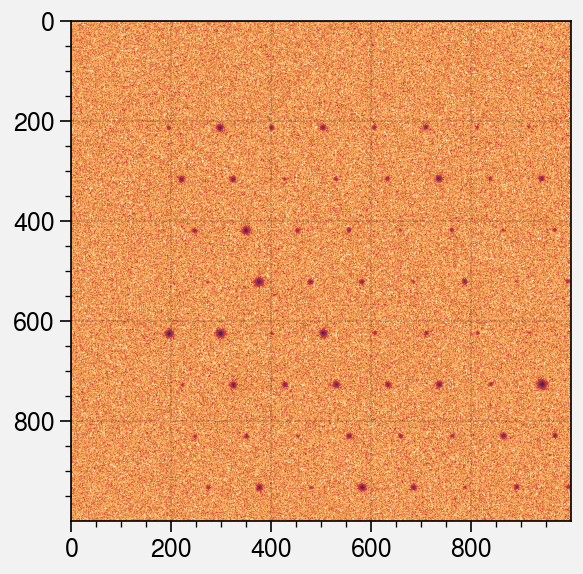

In [114]:
fname = "calexp_00479028-i-R22-S10-det093-3.fits"
with fitsio.FITS("/Users/beckermr/Downloads/" + fname) as f:
    d = f[1].read()

fig, axs = pplt.subplots()
axs.imshow(np.arcsinh(d[:1000, :1000]))

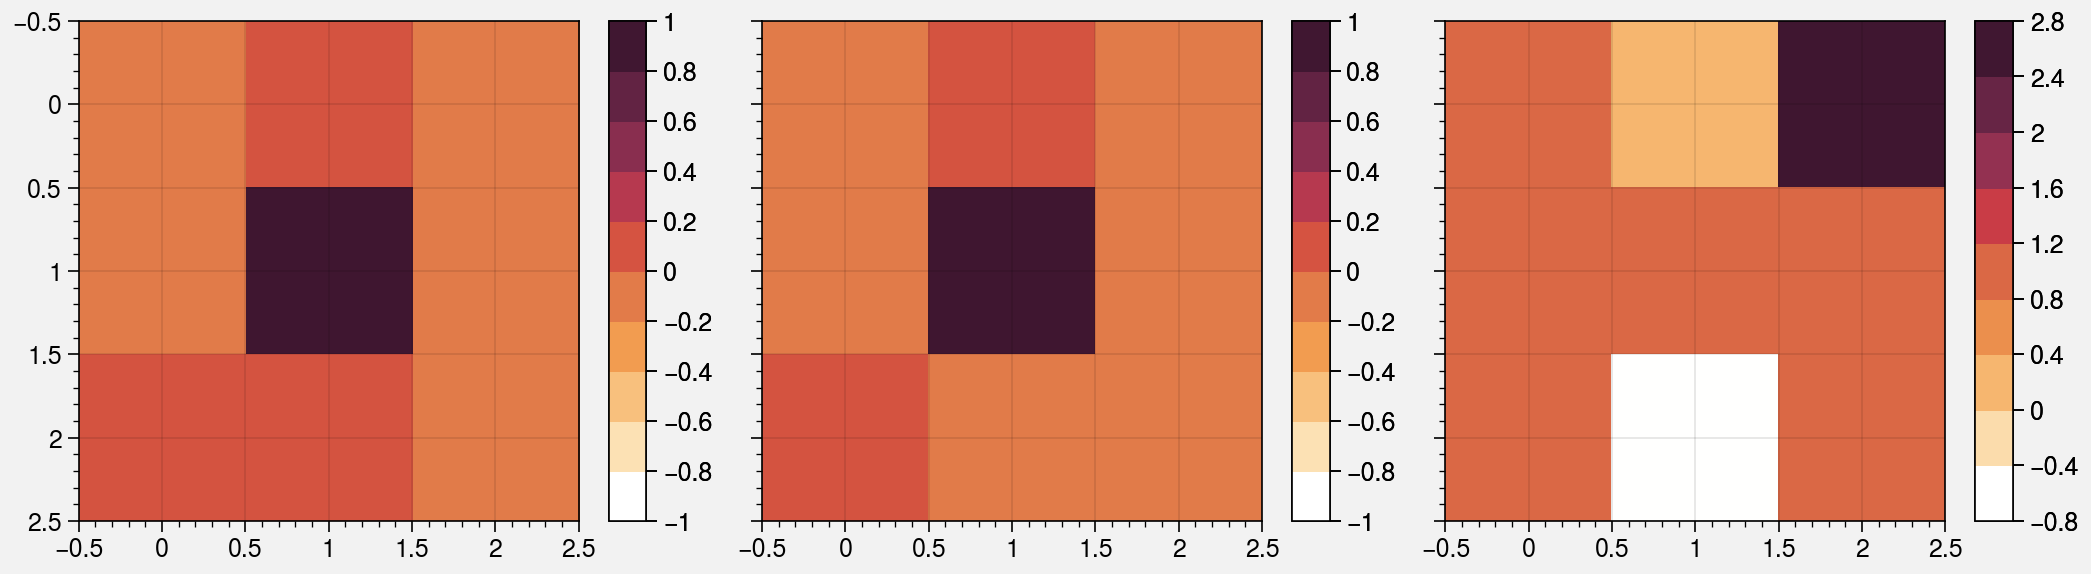

In [115]:
fig, axs = pplt.subplots(ncols=3)

mat = _meas_fname("calexp_00479028-i-R22-S10-det093-3.fits")
axs[0].imshow(mat / mat[1, 1], colorbar='r', vmin=-1, vmax=1)

matc = _meas_fname("calexp_00479028-i-R22-S10-det093_corrected.fits")
axs[1].imshow(matc / matc[1, 1], colorbar='r', vmin=-1, vmax=1)

axs[2].imshow(matc / mat, colorbar='r')

In [229]:
mat = _meas_fname("calexp_00479028-i-R22-S10-det093-3.fits")
print(mat / mat[1, 1])

[[-5.28532770e-03  9.71789902e-04 -4.03153736e-05]
 [-6.16722860e-03  1.00000000e+00 -5.71453076e-03]
 [ 1.41525166e-03  3.80889999e-04 -5.87690285e-03]]


In [90]:
d.shape

(4000, 4072)

In [116]:
import galsim

In [184]:
fname = "calexp_00479028-i-R22-S10-det093.fits"

with fitsio.FITS("/Users/beckermr/Downloads/" + fname) as f:
    d = f[1].read()
im = d[:190, :700+190]

In [185]:
nse = galsim.CorrelatedNoise(galsim.ImageD(im/np.std(im), scale=1), scale=1)

array([[-3.08324704e-03, -2.32565872e-03, -2.49362899e-03],
       [-9.97399593e-04,  1.00001118e+00, -9.97399593e-04],
       [-2.49362899e-03, -2.32565872e-03, -3.08324704e-03]])

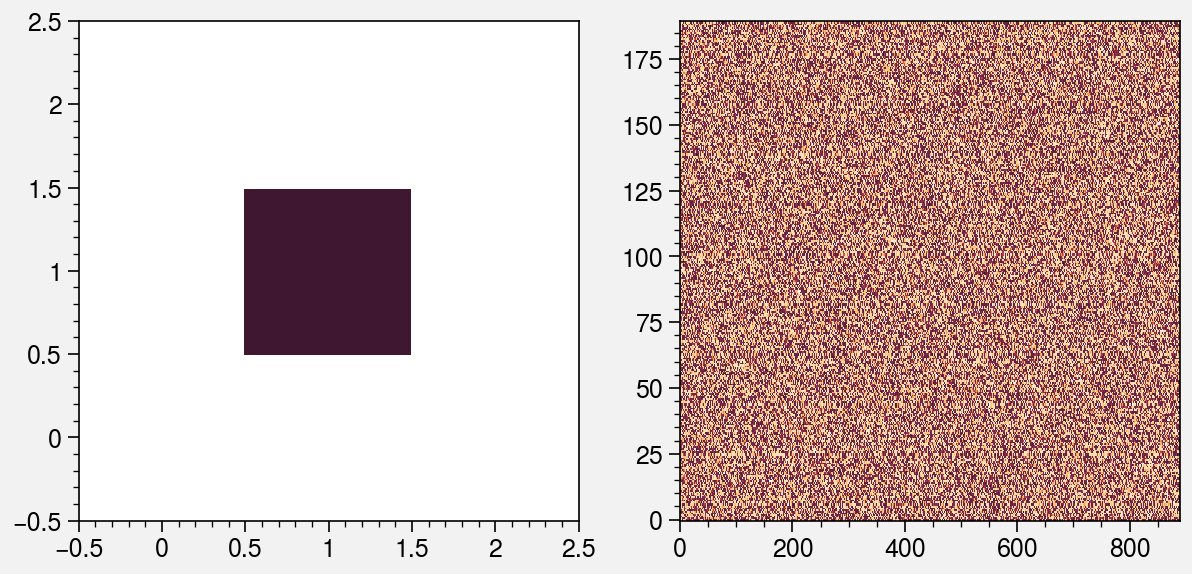

In [186]:
dim = galsim.ImageD(3, 3)
fig, axs = pplt.subplots(ncols=2, sharex=0, sharey=0)
axs[0].pcolormesh(nse.drawImage(image=dim).array)
axs[1].pcolormesh(np.arcsinh(im))

dim.array

array([[-3.08324704e-03, -2.32565872e-03, -2.49362899e-03],
       [-9.97399593e-04,  1.00001118e+00, -9.97399593e-04],
       [-2.49362899e-03, -2.32565872e-03, -3.08324704e-03]])

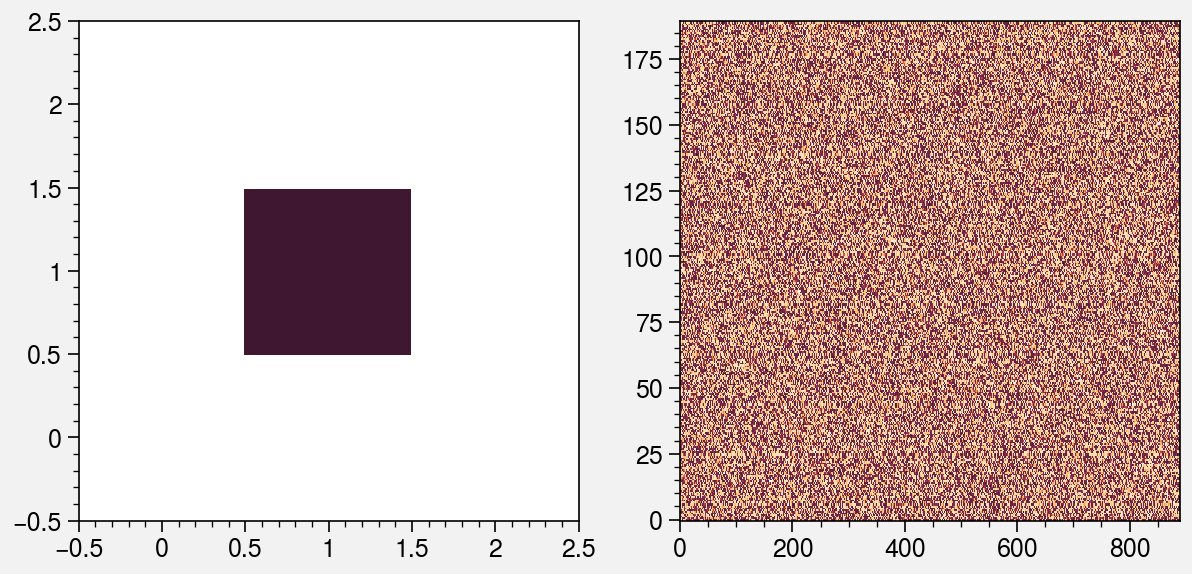

In [180]:
dim = galsim.ImageD(3, 3)
fig, axs = pplt.subplots(ncols=2, sharex=0, sharey=0)
axs[0].pcolormesh(nse.drawImage(image=dim).array)
axs[1].pcolormesh(np.arcsinh(im))

dim.array

In [187]:
import ngmix

In [190]:
def make_obs(seed, dim=101, scale=0.2):
    cen = (dim-1)/2
    rng = np.random.RandomState(seed=seed)
    im = rng.normal(size=(dim, dim))
    nse = rng.normal(size=(dim, dim))
    wgt = np.ones_like(im)
    jac = ngmix.DiagonalJacobian(scale=scale, row=cen, col=cen)
    psf = galsim.Gaussian(fwhm=0.8).drawImage(nx=dim, ny=dim, scale=scale)
    psf_obs = ngmix.Observation(
        image=psf.array,
        weight=wgt,
        jacobian=jac,
    )
    return ngmix.Observation(
        image=im,
        noise=nse,
        weight=wgt,
        jacobian=jac,
        psf=psf_obs,
    )

In [191]:
obs = make_obs(10)

In [192]:
from ngmix.metacal import get_all_metacal

In [195]:
fn = get_all_metacal(obs, step=0.01, fixnoise=True, use_noise_image=True, rng=np.random.RandomState(seed=10))
nofn = get_all_metacal(obs, step=0.01, fixnoise=False, use_noise_image=True, rng=np.random.RandomState(seed=10))

In [196]:
meas_cf(fn["1p"].image)

array([[0.15166262, 0.28962817, 0.16403367],
       [0.28976188, 0.48499626, 0.2896738 ],
       [0.16443472, 0.28945718, 0.15103629]])

In [197]:
meas_cf(nofn["1p"].image)

array([[0.06915518, 0.14229268, 0.07451944],
       [0.13092831, 0.23187673, 0.13034696],
       [0.07519142, 0.14259874, 0.0688434 ]])

In [198]:
np.mean(np.random.poisson(lam=100, size=10_000))

99.89

In [199]:
import galsim

In [200]:
d = galsim.random.PoissonDeviate(seed=10, mean=100)

In [202]:
v = np.zeros(10000)
d.generate(v)

In [203]:
np.mean(v)

100.0008

In [205]:
noise = galsim.noise.PoissonNoise(sky_level=100)

In [210]:
im = galsim.ImageD(1000, 1000)
print(im[1, 1])
noise.applyTo(im)

0.0


In [211]:
np.mean(im.array)

0.004285

In [209]:
im.array

array([[-11.,  12.,  10., ...,  -2.,  15.,   1.],
       [  9.,  -5.,   5., ...,  -5., -14.,  -6.],
       [  7.,   0.,  -2., ...,   4.,  -7.,  -4.],
       ...,
       [ -9.,  -8.,   0., ...,   1.,   6., -29.],
       [  7., -10.,  -2., ...,  -1.,   9.,  -4.],
       [ 20., -12.,   9., ...,  -1.,  -3.,   5.]])

(<matplotlib.lines.Line2D at 0x1806c2590>,)

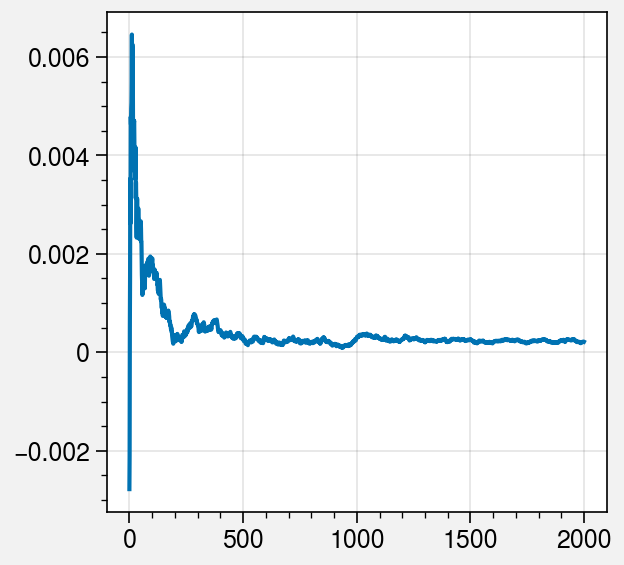

In [228]:
rng = np.random.RandomState(seed=10)

covs = []
tot_covs = []
dim = 101
for _ in range(2000):
    # im = rng.poisson(size=(dim, dim), lam=100) - 100
    im = rng.normal(size=(dim, dim))
    covs.append(meas_cf(im))
    tot_covs.append(np.mean(covs, axis=0))

fig, axs = pplt.subplots()
i, j = 0, 1
v = [cov[i, j] for cov in tot_covs]
axs.plot(v)